In [1]:
%pip install torch torchvision torchaudio scikit-learn matplotlib tqdm pandas

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Device: cuda


Epoch 1 [Training]: 100%|██████████| 80/80 [00:02<00:00, 35.74it/s, loss=0.906]



Epoch 1 - Train Loss: 1.0558, Val Loss: 0.9615, Train Acc: 0.4225, Val Acc: 0.5028


Epoch 2 [Training]: 100%|██████████| 80/80 [00:01<00:00, 44.01it/s, loss=0.766]



Epoch 2 - Train Loss: 0.8548, Val Loss: 0.7925, Train Acc: 0.7182, Val Acc: 0.8011


Epoch 3 [Training]: 100%|██████████| 80/80 [00:01<00:00, 42.84it/s, loss=0.556]



Epoch 3 - Train Loss: 0.6957, Val Loss: 0.7276, Train Acc: 0.8838, Val Acc: 0.8260


Epoch 4 [Training]: 100%|██████████| 80/80 [00:01<00:00, 49.03it/s, loss=1.01] 



Epoch 4 - Train Loss: 0.6386, Val Loss: 0.7155, Train Acc: 0.9221, Val Acc: 0.8453


Epoch 5 [Training]: 100%|██████████| 80/80 [00:01<00:00, 54.46it/s, loss=0.552]



Epoch 5 - Train Loss: 0.6162, Val Loss: 0.7080, Train Acc: 0.9419, Val Acc: 0.8343


Epoch 6 [Training]: 100%|██████████| 80/80 [00:01<00:00, 56.77it/s, loss=0.551]



Epoch 6 - Train Loss: 0.6021, Val Loss: 0.7026, Train Acc: 0.9538, Val Acc: 0.8481


Epoch 7 [Training]: 100%|██████████| 80/80 [00:01<00:00, 54.41it/s, loss=0.553]



Epoch 7 - Train Loss: 0.5974, Val Loss: 0.6992, Train Acc: 0.9593, Val Acc: 0.8481


Epoch 8 [Training]: 100%|██████████| 80/80 [00:01<00:00, 56.39it/s, loss=0.552]



Epoch 8 - Train Loss: 0.5914, Val Loss: 0.6964, Train Acc: 0.9621, Val Acc: 0.8591


Epoch 9 [Training]: 100%|██████████| 80/80 [00:01<00:00, 54.35it/s, loss=0.551]



Epoch 9 - Train Loss: 0.5888, Val Loss: 0.6980, Train Acc: 0.9660, Val Acc: 0.8591


Epoch 10 [Training]: 100%|██████████| 80/80 [00:01<00:00, 59.31it/s, loss=0.551]



Epoch 10 - Train Loss: 0.5880, Val Loss: 0.7007, Train Acc: 0.9656, Val Acc: 0.8564


Epoch 11 [Training]: 100%|██████████| 80/80 [00:01<00:00, 54.74it/s, loss=0.552]



Epoch 11 - Train Loss: 0.5864, Val Loss: 0.7024, Train Acc: 0.9668, Val Acc: 0.8591


Epoch 12 [Training]: 100%|██████████| 80/80 [00:01<00:00, 54.35it/s, loss=0.601]



Epoch 12 - Train Loss: 0.5853, Val Loss: 0.7044, Train Acc: 0.9672, Val Acc: 0.8481


Epoch 13 [Training]: 100%|██████████| 80/80 [00:01<00:00, 55.15it/s, loss=0.555]



Epoch 13 - Train Loss: 0.5831, Val Loss: 0.7016, Train Acc: 0.9708, Val Acc: 0.8564
⛔ Early stopping triggered


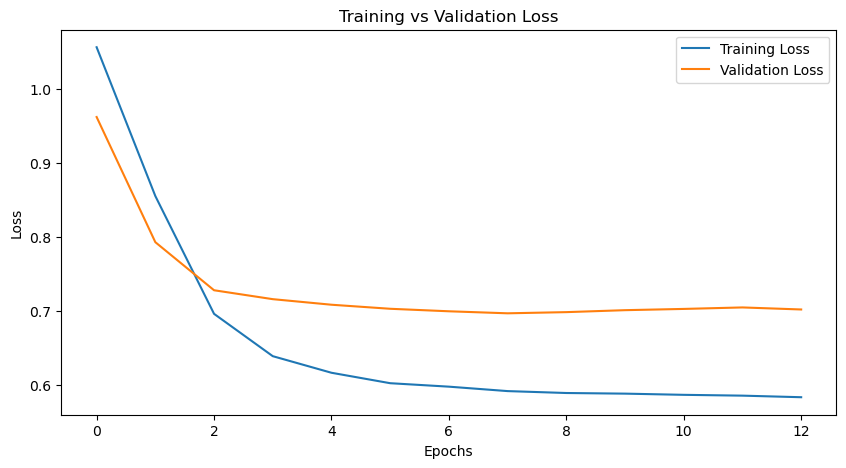

C:\Users\kikoo\AppData\Local\Temp\ipykernel_5512\45894273.py:149: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pt"))



Classification Report:
              precision    recall  f1-score   support

     Negatif       0.89      0.77      0.83       173
      Neutre       0.79      0.83      0.81       236
     Positif       0.91      0.94      0.93       315

    accuracy                           0.86       724
   macro avg       0.86      0.85      0.85       724
weighted avg       0.87      0.86      0.86       724



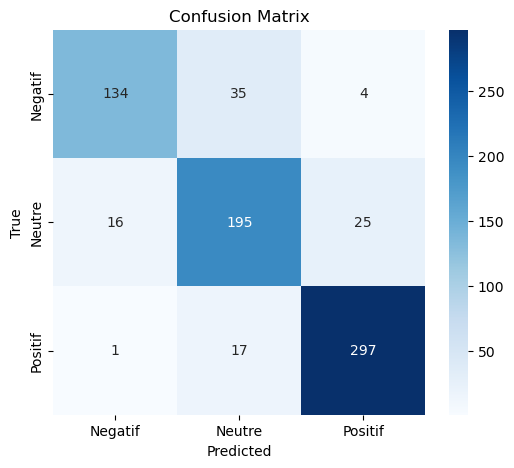

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

# ✅ GPU seulement
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# 📁 Chargement des données
df = pd.read_csv("Data/Data_clean/Comments_clean.csv")
df = df.dropna(subset=["Comments"])

# 🎯 Encodage des étiquettes
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df["Sentiments_encoded"] = label_encoder.fit_transform(df["Sentiments"])

# ✂️ Division des données
X_temp, X_test, y_temp, y_test = train_test_split(df["Comments"], df["Sentiments_encoded"], test_size=0.2, random_state=42, stratify=df["Sentiments_encoded"])
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.125, random_state=42, stratify=y_temp)  # 0.125 * 0.8 = 0.1

# 🧠 Vectorisation avec CountVectorizer
vectorizer = CountVectorizer(max_features=5000, ngram_range=(1, 2))
vectorizer.fit(X_train)
X_train_vec = vectorizer.transform(X_train).toarray()
X_val_vec = vectorizer.transform(X_val).toarray()
X_test_vec = vectorizer.transform(X_test).toarray()

# 📦 Dataset personnalisé
class CommentDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = CommentDataset(X_train_vec, y_train)
val_dataset = CommentDataset(X_val_vec, y_val)
test_dataset = CommentDataset(X_test_vec, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

# 🧱 Modèle LSTM
class SentimentLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, dropout):
        super(SentimentLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=n_layers, batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.unsqueeze(1)  # [batch_size, 1, input_dim]
        lstm_out, _ = self.lstm(x)
        out = self.dropout(lstm_out[:, -1, :])
        out = self.fc(out)
        return self.softmax(out)

input_dim = X_train_vec.shape[1]
model = SentimentLSTM(input_dim=input_dim, hidden_dim=128, output_dim=3, n_layers=2, dropout=0.5)
model = model.to(device)

# 🔧 Entraînement
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
best_val_loss = float('inf')
patience = 5
epochs_no_improve = 0

for epoch in range(30):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1} [Training]")
    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        loop.set_postfix(loss=loss.item())

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss = val_loss / len(val_loader.dataset)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"\nEpoch {epoch+1} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print("⛔ Early stopping triggered")
            break

# 📉 Graphique des pertes
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

# ✅ Évaluation finale
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# 📊 Rapport de classification
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

# 📌 Matrice de confusion
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
